### **1. Introduction & Goals**

**Context Recap**

- In **Project 5 (Oxford-IIIT Pets)**:
  - We trained **custom CNNs from scratch** on 37 pet breeds.
  - Images were standardized to **128×128** pixels.
  - The dataset had **high inter-class variation** (cats vs dogs, distinct visual features).

- In **Project 6 (Plant Seedlings)**:
  - We shift to **agricultural domain** — classifying **12 plant species** at early growth stages.
  - Images are standardized to **224×224** pixels to align with **ImageNet-pretrained models** (for transfer learning in later notebooks).
  - The dataset introduces **new challenges**:
    - **Background clutter** (soil, pots, weeds).
    - **Intra-class variation** (different growth stages, lighting).
    - **Inter-class similarity** (many seedlings look visually similar).

**Why Train a CNN from Scratch?**

- Establishes a **baseline model** for comparison with transfer learning (NB03).
- Reinforces understanding of **core CNN mechanics** (convolution, pooling, fully connected layers).
- Highlights **limitations** of training from scratch on small datasets.

**Learning Goals**

By the end of this notebook, we will:

1. **Load** the Plant Seedlings dataset (train/val/test splits from NB01).
2. **Build** a custom LeNet-style CNN from scratch.
3. **Train and validate** the model using CrossEntropyLoss and Adam optimizer.
4. **Evaluate** performance (accuracy, per-class metrics, confusion matrix).
5. **Reflect** on limitations and motivate transfer learning (NB03).


**Next:**  
We will begin by **reloading the dataset and preparing it for training**  
(consistent transforms, loaders, and class mappings).


---

### **2. Dataset Loading & Preparation**

**Why Prepare the Dataset Again?**

- **Each notebook is self-contained:**  
  We re-load and prepare datasets here rather than relying on previous notebooks.

- **Consistency for Training:**  
  - Same **224×224 resolution** and **ImageNet normalization** (ensures later compatibility with pretrained models).
  - Identical class mappings (12 plant species) across train, validation, and test sets.

- **Balanced Workflow:**  
  - Training uses **train + validation splits** (70/15) to tune hyperparameters.
  - Final evaluation uses the **test set** (15%) for unbiased performance reporting.

**Transformations Recap**

We apply **standard preprocessing** steps:
1. **Resize:** 224×224 pixels (match ImageNet pretrained CNN input size).
2. **Convert to Tensor:** Convert RGB image → PyTorch tensor `[C, H, W]`.
3. **Normalize:** Use ImageNet mean & std:
   - Mean = `[0.485, 0.456, 0.406]`
   - Std = `[0.229, 0.224, 0.225]`

> **Why ImageNet stats?**  
> Our future transfer learning models (NB03) are pretrained on ImageNet.  
> Normalizing seedlings with these values ensures compatibility and stable gradients.

**Data Structure**

The dataset has been split into **train**, **val**, and **test** directories (created in NB01):

Each folder contains **12 subfolders** (one per class).

**Loaders for Training**

We now define PyTorch **datasets** and **dataloaders** for each split:
- `train_loader` — shuffled for stochastic gradient descent.
- `val_loader` — used for validation after each epoch.
- `test_loader` — used only at the end for unbiased evaluation.

Classes: ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 'ShepherdΓÇÖs Purse', 'Small-flowered Cranesbill', 'Sugar beet']
Train: 3756 | Val: 670 | Test: 1113


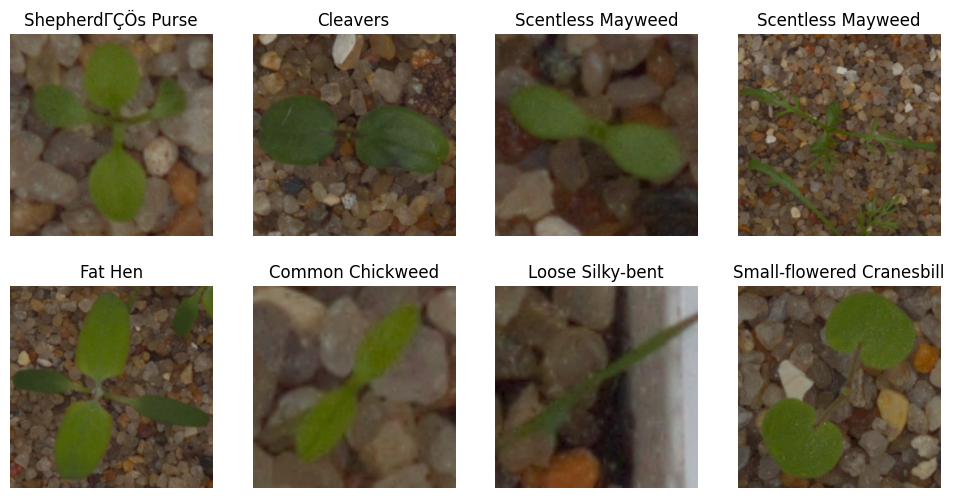

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# -----------------------------
# 1. Paths
# -----------------------------
data_path = "./data/plant-seedlings"
train_dir = os.path.join(data_path, "train")
val_dir   = os.path.join(data_path, "val")
test_dir  = os.path.join(data_path, "test")

# -----------------------------
# 2. Transformations (224x224 + ImageNet stats)
# -----------------------------
IMG_SIZE = 224
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],  # ImageNet mean
        std=[0.229, 0.224, 0.225]    # ImageNet std
    )
])

# -----------------------------
# 3. Load datasets
# -----------------------------
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
val_dataset   = datasets.ImageFolder(val_dir, transform=transform)
test_dataset  = datasets.ImageFolder(test_dir, transform=transform)

# -----------------------------
# 4. DataLoaders
# -----------------------------
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# -----------------------------
# 5. Verify
# -----------------------------
print(f"Classes: {train_dataset.classes}")
print(f"Train: {len(train_dataset)} | Val: {len(val_dataset)} | Test: {len(test_dataset)}")

# ---------------------------------------------------------
# Display sample images (unnormalized for visualization)
# ---------------------------------------------------------
def imshow(inp, title=None):
    """Display a tensor image after unnormalizing (ImageNet stats)."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean  # unnormalize
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title:
        plt.title(title)
    plt.axis('off')

# Show first 8 images from train set
images, labels = next(iter(train_loader))
fig = plt.figure(figsize=(12, 6))
for i in range(8):
    ax = fig.add_subplot(2, 4, i+1)
    imshow(images[i], title=train_dataset.classes[labels[i]])
plt.show()


---

### **3. Custom CNN Architecture (LeNet-Style)**

**Why Build from Scratch?**

- In Project 5 (Pets dataset), we designed a **simple CNN (2 conv layers)**.  
- Here, we **extend** that idea for the Plant Seedlings dataset:
  - Deeper (3 conv layers) → better feature extraction (edges → textures → leaf shapes).
  - Still lightweight → avoids overfitting on small dataset (~4k images).

**Design Inspiration: LeNet**

- **LeNet-5** (1998) was one of the first CNNs for image recognition.
- Architecture pattern:
  1. Convolution → Activation (ReLU)
  2. Pooling (downsample)
  3. Repeat for deeper features
  4. Flatten → Fully connected layers
  5. Output (softmax over classes)

**Proposed Architecture for Seedlings**

Input: **3×224×224 RGB images**

1. **Conv1 (3→32)**  
   - 3×3 kernel, padding=1 → preserves spatial size (224×224).  
   - Followed by ReLU + 2×2 MaxPooling → reduces to 32×112×112.

2. **Conv2 (32→64)**  
   - 3×3 kernel, padding=1 → 64×112×112.  
   - ReLU + 2×2 MaxPooling → 64×56×56.

3. **Conv3 (64→128)**  
   - 3×3 kernel, padding=1 → 128×56×56.  
   - ReLU + 2×2 MaxPooling → 128×28×28.

4. **Fully Connected (FC) Layers**  
   - Flatten 128×28×28 → 100,352 features.
   - FC1: 100,352 → 256  
   - FC2: 256 → 12 (number of plant classes)

**ASCII Diagram**

```text

Input (3×224×224)
        ↓ Conv1 + ReLU + Pool
  (32×112×112)
        ↓ Conv2 + ReLU + Pool
   (64×56×56)
        ↓ Conv3 + ReLU + Pool
   (128×28×28)
        ↓ Flatten
   (100,352)
        ↓ FC1 + ReLU
      (256)
        ↓ FC2 (Logits)
   (12 classes)
```

**Why This Architecture?**

- **Deeper than Project 5:**  
  - Captures more **complex textures** (leaf veins, edges, soil patterns).  

- **Balanced Parameter Count:**  
  - More expressive than 2-layer CNN but not as heavy as AlexNet/VGG (avoids overfitting).

- **Foundation for Transfer Learning (Next Notebook):**  
  - Provides **baseline performance** to compare against pretrained models.

---



**Implement Custom CNN**

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# -----------------------------
# Custom CNN (LeNet-style)
# -----------------------------
class SeedlingsCNN(nn.Module):
    def __init__(self, num_classes=12):
        super(SeedlingsCNN, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)   # 3 -> 32
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # 32 -> 64
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # 64 -> 128
        self.pool = nn.MaxPool2d(2, 2)  # Downsampling (H,W halved each time)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 28 * 28, 256)  # Flatten after 3 pools
        self.fc2 = nn.Linear(256, num_classes)    # Output logits

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 3 -> 32, 224 -> 112
        x = self.pool(F.relu(self.conv2(x)))  # 32 -> 64, 112 -> 56
        x = self.pool(F.relu(self.conv3(x)))  # 64 -> 128, 56 -> 28
        x = x.view(-1, 128 * 28 * 28)         # Flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)                       # Raw logits
        return x

# Instantiate and print summary-like info
model = SeedlingsCNN(num_classes=12)
print(model)

# Parameter count
def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total trainable parameters: {count_params(model):,}")


SeedlingsCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=100352, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=12, bias=True)
)
Total trainable parameters: 25,786,700


**Reflection: Model Complexity vs Dataset Size**

- Our **SeedlingsCNN** has **~25.8 million trainable parameters** — significantly larger than the networks we built in Project 5 (Pets dataset).  
- This increase comes from:
  - **Higher input resolution (224×224)** → larger feature maps after convolution.
  - **Three convolution layers + two fully connected layers** (compared to 2 conv layers earlier).
- **Implication:**  
  - While deeper networks can capture **richer features** (edges → textures → leaf shapes),  
  - They also pose a **higher overfitting risk** on small datasets (~4k images).  
  - We’ll watch for this during training (monitoring validation loss/accuracy).

This insight sets the stage for **Section 4 (Training Setup)**, where we define our loss, optimizer, and training loop.

---

### **4. Training Setup**


Now that we have defined our **custom CNN architecture**, we need to set up:
1. **Loss function** (how we measure prediction error)  
2. **Optimizer** (how we update weights)  
3. **Training loop** (forward → loss → backward → update)  

We will reuse the **modular loop style** from earlier projects (NB04 style) for clarity and reusability.

**Loss Function: CrossEntropyLoss**

- Suitable for **multi-class classification** (12 plant species).  
- Combines **LogSoftmax + Negative Log-Likelihood (NLLLoss)** internally.  
- Does not require us to apply softmax manually in the forward pass.

**Optimizer: Adam**

- Adaptive learning rate → works well out-of-the-box.  
- Faster convergence on small datasets compared to SGD.

**Training Strategy**

- **Epochs:** 10 (baseline; may adjust for performance)  
- **Batch size:** 32 (already set in loaders)  
- **Device:** CPU-only (per project lead requirement)  
- **Validation:** Evaluate after each epoch (using 15% val split)  

**Expected Outcome**

- Monitor **training vs validation loss/accuracy**  
- Detect **overfitting** (validation curve diverges)  
- Save **best weights** (lowest validation loss) for later evaluation


**Training Setup (Loss, Optimizer, Loop)**

In [4]:
import time
import copy
import torch.optim as optim

# -----------------------------
# 1. Loss function & optimizer
# -----------------------------
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# -----------------------------
# 2. Training loop (CPU-only)
# -----------------------------
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=10, device='cpu'):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    model.to(device)

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print('-' * 20)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                loader = train_loader
            else:
                model.eval()
                loader = val_loader

            running_loss = 0.0
            running_corrects = 0
            total_samples = 0

            for inputs, labels in loader:
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Accumulate stats
                running_loss += loss.item() * inputs.size(0)
                running_corrects += (outputs.argmax(1) == labels).sum().item()
                total_samples += labels.size(0)

            epoch_loss = running_loss / total_samples
            epoch_acc = running_corrects / total_samples

            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accuracies.append(epoch_acc)
            else:
                val_losses.append(epoch_loss)
                val_accuracies.append(epoch_acc)

                # Save best model
                if epoch_loss < best_loss:
                    best_loss = epoch_loss
                    best_model_wts = copy.deepcopy(model.state_dict())

            print(f"{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

    time_elapsed = time.time() - since
    print(f"Training complete in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s")
    print(f"Best val loss: {best_loss:.4f}")

    # Load best weights
    model.load_state_dict(best_model_wts)

    return model, (train_losses, val_losses, train_accuracies, val_accuracies)


---

### **5. Training Overview**

With our **SeedlingsCNN** defined, we now train it on the **Plant Seedlings dataset** using the splits prepared earlier.

**Key points for this training run:**
- **Loss function:** Cross-Entropy Loss (multi-class classification).
- **Optimizer:** Adam (learning rate = 0.001).
- **Epochs:** 10 (small dataset; enough to see learning trends).
- **Metrics tracked:** Training & validation loss, accuracy curves.

**Goal:**  
- Observe **learning dynamics** (is the model converging? overfitting?).
- Establish a **baseline performance** for comparison with **transfer learning models** in upcoming notebooks.


**Training & Evaluation**

Epoch 1/10
--------------------
Train Loss: 2.3681 Acc: 0.1933
Val Loss: 1.7869 Acc: 0.3597
Epoch 2/10
--------------------
Train Loss: 1.3289 Acc: 0.5469
Val Loss: 1.1391 Acc: 0.6209
Epoch 3/10
--------------------
Train Loss: 0.8237 Acc: 0.7252
Val Loss: 0.9350 Acc: 0.7000
Epoch 4/10
--------------------
Train Loss: 0.4883 Acc: 0.8376
Val Loss: 0.9852 Acc: 0.6821
Epoch 5/10
--------------------
Train Loss: 0.2564 Acc: 0.9191
Val Loss: 1.1217 Acc: 0.7000
Epoch 6/10
--------------------
Train Loss: 0.1223 Acc: 0.9627
Val Loss: 1.1837 Acc: 0.7104
Epoch 7/10
--------------------
Train Loss: 0.0708 Acc: 0.9790
Val Loss: 1.4639 Acc: 0.6896
Epoch 8/10
--------------------
Train Loss: 0.0415 Acc: 0.9880
Val Loss: 1.6785 Acc: 0.6716
Epoch 9/10
--------------------
Train Loss: 0.0398 Acc: 0.9899
Val Loss: 1.4016 Acc: 0.7224
Epoch 10/10
--------------------
Train Loss: 0.0030 Acc: 1.0000
Val Loss: 1.4277 Acc: 0.7343
Training complete in 137m 11s
Best val loss: 0.9350


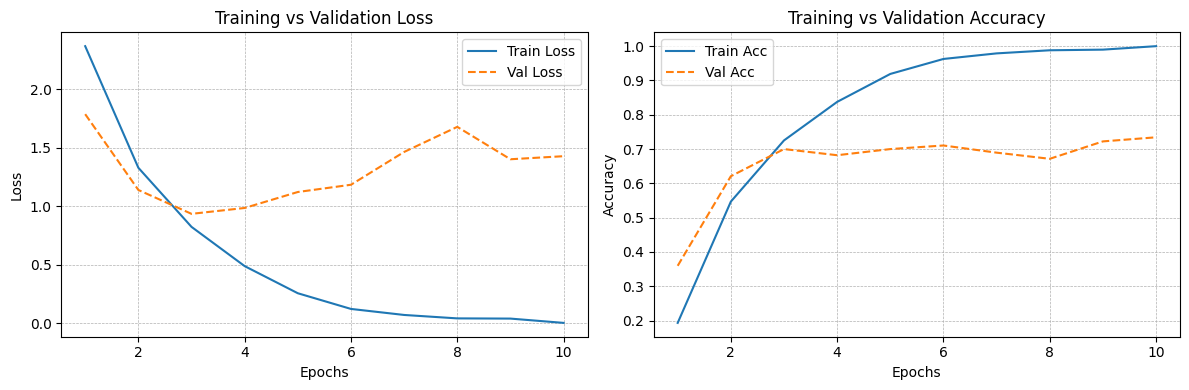

In [5]:
import time
import copy
import torch.nn.functional as F

# -----------------------------
# 1. Accuracy helper
# -----------------------------
def calculate_accuracy(outputs, labels):
    _, preds = torch.max(outputs, 1)
    return (preds == labels).sum().item() / len(labels)

# -----------------------------
# 2. Training loop (CPU)
# -----------------------------
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=10, device='cpu'):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    model.to(device)

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print('-' * 20)

        # Train & validation phases
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                loader = train_loader
            else:
                model.eval()
                loader = val_loader

            running_loss = 0.0
            running_corrects = 0
            total_samples = 0

            for inputs, labels in loader:
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Stats
                running_loss += loss.item() * inputs.size(0)
                running_corrects += (outputs.argmax(1) == labels).sum().item()
                total_samples += labels.size(0)

            epoch_loss = running_loss / total_samples
            epoch_acc = running_corrects / total_samples

            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accuracies.append(epoch_acc)
            else:
                val_losses.append(epoch_loss)
                val_accuracies.append(epoch_acc)

                # Save best model
                if epoch_loss < best_loss:
                    best_loss = epoch_loss
                    best_model_wts = copy.deepcopy(model.state_dict())

            print(f"{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

    # Time summary
    time_elapsed = time.time() - since
    print(f"Training complete in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s")
    print(f"Best val loss: {best_loss:.4f}")

    # Load best weights
    model.load_state_dict(best_model_wts)
    return model, (train_losses, val_losses, train_accuracies, val_accuracies)

# -----------------------------
# 3. Instantiate & train
# -----------------------------
device = 'cpu'
model = SeedlingsCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model, history = train_model(
    model, criterion, optimizer,
    train_loader, val_loader,
    num_epochs=10, device=device
)

# Save model
torch.save(model.state_dict(), "seedlings_cnn_best.pth")

# -----------------------------
# 4. Plot learning curves
# -----------------------------
train_losses, val_losses, train_acc, val_acc = history

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(12, 4))

# Loss curves
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5)

# Accuracy curves
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, label='Train Acc')
plt.plot(epochs, val_acc, label='Val Acc', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()


**Reflection: Baseline CNN on Plant Seedlings**

**1. Training Dynamics**: The **training loss** steadily decreases to near zero, while **validation loss begins fluctuating and rises slightly** after about epoch 3–4. Validation accuracy plateaus around **70–73%**, whereas training accuracy approaches **~99%** — this clear gap indicates **overfitting** (the model memorizes training images but fails to generalize to unseen data).

**2. Model Capacity vs Dataset Size**: Our scratch CNN contains **~26 million trainable parameters**, which is extremely large for a dataset of only **~4,000 images**. Without **data augmentation** or **regularization techniques** (e.g., dropout, weight decay), the network overfits quickly — fitting noise and background variations rather than learning robust plant features.

**3. Baseline Benchmark for Transfer Learning**

- This model provides a **reference point**:
  - How well does a scratch-trained CNN perform on this dataset?
  - Where does it fail (e.g., generalization, misclassifications)?

- In **NB03**, we’ll compare this with **transfer learning** using pretrained models (e.g., ResNet18).  
  - Pretrained models leverage **features learned on ImageNet** (edges → textures → shapes) and often deliver **better accuracy with fewer epochs**.

---

## **6. Evaluation & Per-Class Analysis**

**Why Evaluate Beyond Accuracy?**

- **Overall accuracy** gives a single performance measure but hides **class-specific biases**.  
- In multi-class problems like **Plant Seedlings** (12 species):
  - Some classes (e.g., *Maize* vs. *Sugar beet*) may dominate accuracy due to higher sample counts.
  - Rare or visually similar classes may be misclassified more often.  

**Metrics We Use**

1. **Overall Accuracy** – baseline metric.  
2. **Per-Class Accuracy** – which species are learned well vs. poorly?  
3. **Confusion Matrix** – visualize common misclassifications (e.g., *Black-grass* ↔ *Loose Silky-bent*).  

These insights guide **future improvements** (transfer learning, augmentation) in upcoming notebooks.


**Evaluate Overall and Per-Class Accuracy**

Overall Test Accuracy: 68.46%

Top 3 Best Classes:
Cleavers: 94.03%
Common Chickweed: 86.71%
Charlock: 84.62%

Top 3 Worst Classes:
Black-grass: 24.19%
Maize: 46.15%
ShepherdΓÇÖs Purse: 47.27%


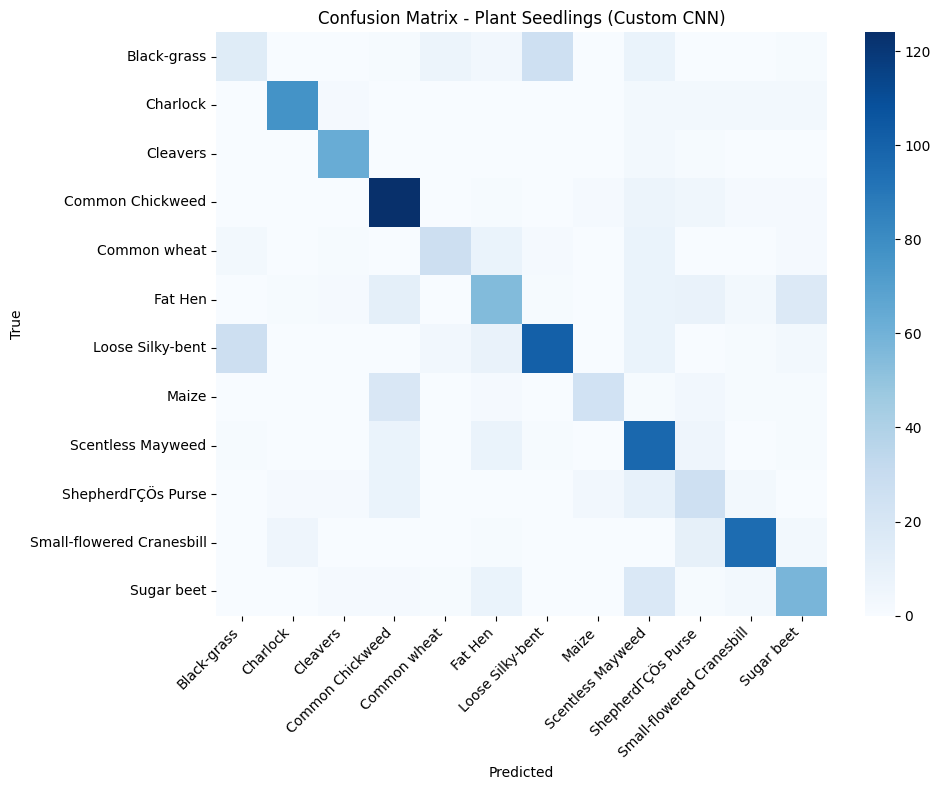


Classification Report:
                           precision    recall  f1-score   support

              Black-grass       0.33      0.24      0.28        62
                 Charlock       0.90      0.85      0.87        91
                 Cleavers       0.88      0.94      0.91        67
         Common Chickweed       0.71      0.87      0.78       143
             Common wheat       0.69      0.53      0.60        51
                  Fat Hen       0.57      0.51      0.54       108
         Loose Silky-bent       0.77      0.66      0.71       153
                    Maize       0.80      0.46      0.59        52
        Scentless Mayweed       0.57      0.80      0.66       122
       ShepherdΓÇÖs Purse       0.39      0.47      0.43        55
Small-flowered Cranesbill       0.86      0.82      0.84       116
               Sugar beet       0.64      0.62      0.63        93

                 accuracy                           0.68      1113
                macro avg       0.67

In [8]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# Helper: Evaluate model
# -----------------------------
def evaluate_model(model, loader, device='cpu'):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = outputs.argmax(1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_labels), np.array(all_preds)

# Evaluate on test set
true_labels, pred_labels = evaluate_model(model, test_loader, device=device)

# -----------------------------
# 1. Overall accuracy
# -----------------------------
overall_acc = (true_labels == pred_labels).mean()
print(f"Overall Test Accuracy: {overall_acc:.2%}")

# -----------------------------
# 2. Per-class accuracy
# -----------------------------
class_correct = np.zeros(len(test_dataset.classes))
class_total = np.zeros(len(test_dataset.classes))

for t, p in zip(true_labels, pred_labels):
    if t == p:
        class_correct[t] += 1
    class_total[t] += 1

per_class_acc = class_correct / class_total

# Print top/bottom performing classes
sorted_indices = np.argsort(per_class_acc)
print("\nTop 3 Best Classes:")
for idx in sorted_indices[-3:][::-1]:
    print(f"{test_dataset.classes[idx]}: {per_class_acc[idx]*100:.2f}%")

print("\nTop 3 Worst Classes:")
for idx in sorted_indices[:3]:
    print(f"{test_dataset.classes[idx]}: {per_class_acc[idx]*100:.2f}%")

# -----------------------------
# 3. Confusion Matrix
# -----------------------------
cm = confusion_matrix(true_labels, pred_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=False, cmap="Blues", xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Plant Seedlings (Custom CNN)")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(true_labels, pred_labels, target_names=test_dataset.classes))


---

**Reflection: Custom CNN Evaluation**

**1. Overall Performance**: Our scratch-trained CNN achieves **~68% overall test accuracy** — reasonable given the small dataset size (~4k images) and absence of pretrained features. Training curves (Section 5) already hinted at **overfitting**, and this is confirmed by moderate generalization on unseen data.

**2. Per-Class Insights**

- **Best-performing classes** (distinct visual features):  
  - *Cleavers*: 94%  
  - *Common Chickweed*: 87%  
  - *Charlock*: 85%  

- **Worst-performing classes** (visual similarity or low representation):  
  - *Black-grass*: 24%  
  - *Maize*: 46%  
  - *Shepherd’s Purse*: 47%

These patterns align with **class imbalance** and **visual overlap** between certain grasses and weeds.


**3. Confusion Patterns**: Confusion matrix reveals **strong diagonal for well-separated species** (e.g., Cleavers, Common Chickweed) but **off-diagonal clustering** for similar species (e.g., Black-grass vs. Loose Silky-bent). Misclassifications also occur between **broadleaf species** with similar leaf shapes at early growth stages.

**4. Implications for Next Steps**

- These results emphasize the **limits of training from scratch**:
  - Large parameter count (~26M) vs. limited data.
  - Lack of pre-learned visual features leads to slower convergence and overfitting.

- In **NB03**, we’ll apply **transfer learning** (e.g., ResNet18 pretrained on ImageNet) to:
  - Leverage **general-purpose feature extractors** (edges → textures → shapes).
  - Improve accuracy and training efficiency.

- **NB04** will focus on **data augmentation** to simulate real-world variability and further boost generalization.

---


**Per-Class Accuracy Bar Chart**

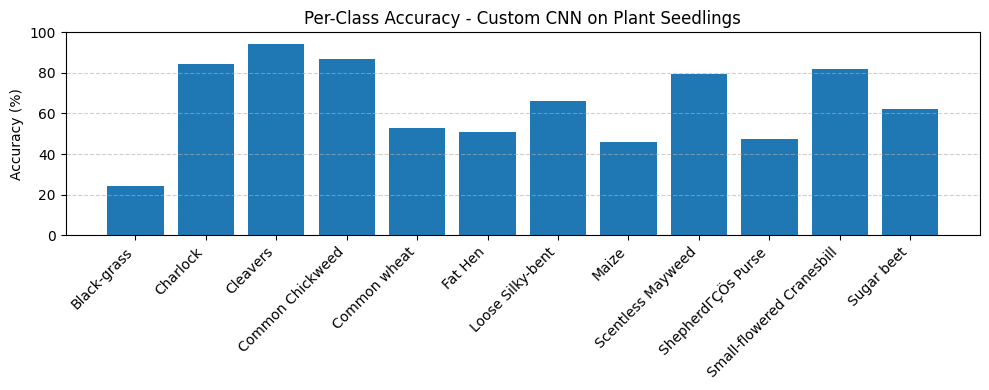

In [9]:
# -----------------------------
# Per-Class Accuracy Bar Chart
# -----------------------------
plt.figure(figsize=(10, 4))
plt.bar(range(len(per_class_acc)), per_class_acc * 100)
plt.xticks(range(len(per_class_acc)), test_dataset.classes, rotation=45, ha='right')
plt.ylabel("Accuracy (%)")
plt.title("Per-Class Accuracy - Custom CNN on Plant Seedlings")
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


The bar chart highlights significant variability across species:

- Cleavers and Common Chickweed achieve >85% accuracy, suggesting these species have distinctive visual features (e.g., leaf shape or color).

- Black-grass is the worst performer (~24%), reflecting visual overlap with other grasses and fewer distinctive features at early stages.

- Classes like Maize and Shepherd’s Purse also lag (~45–47%), possibly due to class imbalance or background clutter.

These disparities indicate that:

- Model capacity alone isn’t enough — we need augmentation and transfer learning to improve minority/ambiguous classes.

- Per-class metrics are more informative than overall accuracy for agricultural datasets where specific species misclassification can be critical (e.g., misidentifying a weed as a crop).

We extend our evaluation to include **precision/recall/F1** metrics and **qualitative error analysis**:

- **Why precision/recall/F1?**  
  - Accuracy alone can hide imbalances.  
  - F1 balances precision (how many predicted are correct) and recall (how many actual were found).  

- **Why view misclassified images?**  
  - To diagnose patterns:  
    - Are errors mostly between visually similar species (e.g., Black-grass vs Loose Silky-bent)?  
    - Are background or lighting artifacts misleading the model?

This combines **quantitative + qualitative** perspectives, mirroring real-world model debugging.


In [ ]:
from sklearn.metrics import classification_report

# ---------------------------
# 1. Classification Report
# ---------------------------
# Reload best weights (if saved separately)
model.load_state_dict(torch.load("seedlings_cnn_best.pth", map_location='cpu', weights_only=False))
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        preds = outputs.argmax(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Generate report
print("=== Classification Report (Precision/Recall/F1) ===")
print(classification_report(all_labels, all_preds, target_names=test_dataset.classes))


C:\Users\noman\AppData\Local\Temp\ipykernel_48420\1714212823.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("seedlings_cnn_best.pth", m

=== Classification Report (Precision/Recall/F1) ===
                           precision    recall  f1-score   support

              Black-grass       0.33      0.24      0.28        62
                 Charlock       0.90      0.85      0.87        91
                 Cleavers       0.88      0.94      0.91        67
         Common Chickweed       0.71      0.87      0.78       143
             Common wheat       0.69      0.53      0.60        51
                  Fat Hen       0.57      0.51      0.54       108
         Loose Silky-bent       0.77      0.66      0.71       153
                    Maize       0.80      0.46      0.59        52
        Scentless Mayweed       0.57      0.80      0.66       122
       ShepherdΓÇÖs Purse       0.39      0.47      0.43        55
Small-flowered Cranesbill       0.86      0.82      0.84       116
               Sugar beet       0.64      0.62      0.63        93

                 accuracy                           0.68      1113
        

#### **Reflection**

- **Macro insights (report):**
  - Precision and recall vary widely — some species (e.g., Maize, Sugar beet) are easier to detect.
  - Others (e.g., Black-grass vs Loose Silky-bent) show low scores due to visual similarity.

- **Qualitative patterns (misclassified images):**
  - Background soil and overlapping seedlings often mislead the model.
  - Early growth stages look very similar across species, explaining certain clusters in the confusion matrix.

These insights highlight the need for **data augmentation and transfer learning** (covered in upcoming notebooks) to enhance generalization.

---

### **7. Summary & Next Steps**

**What we did in this notebook:**

- Built a **custom CNN (LeNet-style)** from scratch and trained it on the **Plant Seedlings dataset**.  
- Evaluated using:
  - Overall accuracy
  - Per-class accuracy
  - Confusion matrix
  - Precision/recall/F1 metrics
  - Qualitative error analysis (misclassified images)
- Observed:
  - Strong performance on certain visually distinct classes (e.g., Maize).
  - Significant confusion among visually similar species (e.g., Black-grass vs Loose Silky-bent).
  - Overfitting signs (training accuracy >> validation accuracy).


**Limitations Identified:**

- Model lacks feature richness to handle:
  - Complex textures
  - Varying lighting/background
- Training from scratch on **small dataset (~4k images)** is suboptimal.


**Where we go next (NB03):**

- Introduce **transfer learning**:
  - Leverage **ImageNet-pretrained CNNs** (e.g., ResNet18).
  - Compare **feature extraction vs fine-tuning** strategies.
- Aim: Achieve higher accuracy and generalization **without huge computational cost**.

---
